## Import libraries and such

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load in an iris image and test Daugmans integro-differential operator

(240, 320, 3)
981.4745098039226


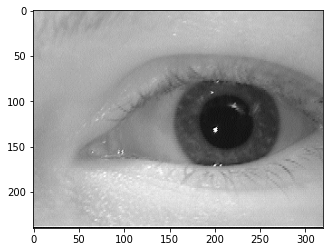

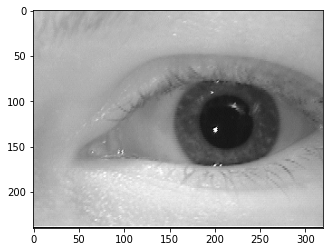

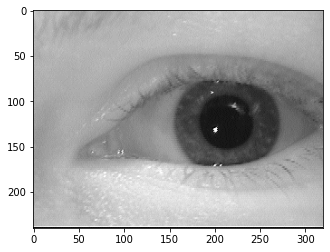

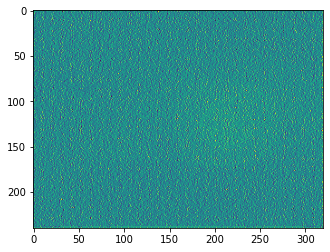

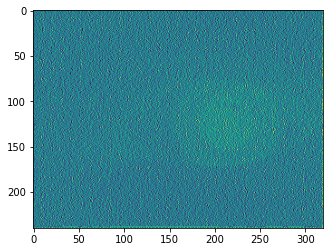

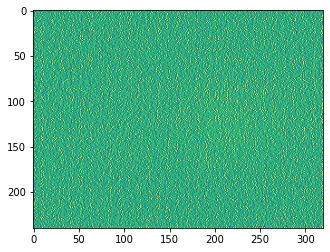

In [2]:
img = cv2.imread("MMU-Iris-Database/10_left_1.bmp").astype(np.double) / 255
img2 = cv2.cvtColor(cv2.imread("MMU-Iris-Database/10_left_1.bmp"), cv2.COLOR_BGR2GRAY)
print(img.shape)
print((np.abs(img[:, :, 2] - img[:, :, 1])).sum())
plt.imshow(img[:, :, 0], cmap="gray")
plt.show()
plt.imshow(img[:, :, 1], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 2])
plt.show()

## Rename the data to be easier accessible

### Daugmans integro-differential operator

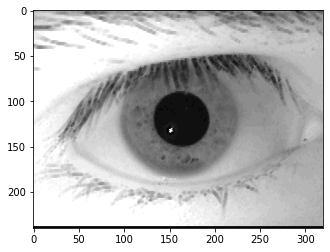

(240, 320)
Optimal location and radius:  
x=163.0
y=116.0
r=29.0
Optimal location and radius:  
x=160.0
y=119.0
r=64.0


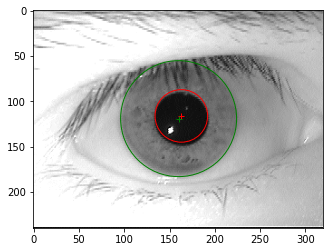

In [3]:
from scipy.signal import convolve2d
from matplotlib.patches import Circle
from typing import Optional

def circle_mask(r, xmax: int, ymax: int, x0r: int, y0r: int, lateral: bool=False) -> np.ndarray:
    circle = np.zeros((r + 1, r + 1)).astype(bool)
    circle_x, circle_y = np.meshgrid(np.arange(0, r + 1), np.arange(0, r + 1))
    circle_y = np.flip(circle_y, axis=0)
    dist = np.hstack([np.abs(circle_x ** 2 + circle_y ** 2 - r ** 2), np.ones(r + 1)[:, np.newaxis]*1e10])
    x0 = 0
    y0 = 0
    circle[y0, x0] = True
    incomplete_circle = True
    while incomplete_circle:

        if dist[y0, x0 + 1] < dist[y0 + 1, x0 + 1]:
            if dist[y0, x0 + 1] < dist[y0 + 1, x0]:
                x0 += 1
            else:
                y0 += 1
        elif dist[y0 + 1, x0 + 1] < dist[y0 + 1, x0]:
            y0 += 1
            x0 += 1
        else:
            y0 += 1
        circle[y0, x0] = True
        if y0 == r:
            incomplete_circle = False

    circle = np.hstack([np.flip(circle[:, 1:], axis=1), circle])
    circle = np.vstack([circle, np.flip(circle[:-1, :], axis=0)])
    if lateral:
        circle[:, r//2 + 1:-r//2] = False
    rxup = r
    ryup = r
    rxdown = r
    rydown = r
    if y0r < r:
        ryup = y0r
        circle = circle[(r - y0r):, :]
    if x0r < r:
        rxup = x0r
        circle = circle[:, (r - x0r):]
    if y0r + r + 1 > ymax:
        diff = y0r + r + 1 - ymax
        rydown = ymax - y0r - 1
        circle = circle[:-diff, :]
    if x0r + r + 1 > xmax:
        diff = x0r + r + 1 - xmax
        rxdown = xmax - x0r - 1
        circle = circle[:, :-diff]
    
    return circle, ryup, rydown, rxup, rxdown

def G(x: float, sigma: float=1.0) -> float:
    return np.exp(-x**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def LineIntegral(img: np.ndarray, r: int, x0: int, y0: int, lateral: bool=False) -> float:
    circle, ryup, rydown, rxup, rxdown = circle_mask(r, lateral=lateral, xmax=img.shape[1], ymax=img.shape[0], x0r=x0, y0r=y0)
    a = img[y0 - ryup:y0 + rydown + 1, x0 - rxup:x0 + rxdown + 1][circle]
    return (img[y0 - ryup:y0 + rydown + 1, x0 - rxup:x0 + rxdown + 1][circle]).sum() / circle.sum()

def drLineIntegral(img: np.ndarray, r: int, x0: int, y0: int, lateral: bool=False) -> float:
    return LineIntegral(img, r + 1, x0, y0, lateral=lateral) - LineIntegral(img, r, x0, y0, lateral=lateral)

def drLineIntegralMulti(img: np.ndarray, rmin: int, rmax: int, x0: int, y0: int, lateral: bool=False) -> np.ndarray:
    lint = np.zeros(rmax - rmin + 2)
    for r in range(rmin, rmax + 2):
        lint[r - rmin] = LineIntegral(img, r, x0, y0, lateral=lateral)
    return np.diff(lint)

def ConvolveGaussiandrLI(drLIM: np.ndarray, filter_size: int=3, sigma: float=1.0) -> np.ndarray:

    gf = np.exp(-(np.arange(filter_size) - filter_size // 2)**2/(2*sigma**2)) / (np.sqrt(2 * np.pi) * sigma)
    return np.convolve(drLIM, gf, mode="same")

def FindEdge(
        img: np.ndarray, 
        rmin: int, 
        rmax: int, 
        search_radius: int=5, 
        filter_size: int=3, 
        sigma: float=1.0, 
        lateral: bool=False, 
        plot_img: Optional[np.ndarray]=None, 
        plot_: bool=True,
        x0: Optional[int]=None,
        y0: Optional[int]=None
        ):
    
    # This seems like a good way to estimate a first guess of middle of eye,
    # but might be troublesome for darskinned people
    if x0 is None or y0 is None:
        img_x0y0 = (img < 0.07).astype(int)
        f = np.ones((20, 20))
        res = convolve2d(img_x0y0, f, mode="same")
        top_index = np.unravel_index(np.argmax(res), res.shape)
    else:
        top_index = (y0, x0)

    n = search_radius*2 + 1
    max_blur = np.zeros((n, n))
    opt_r = np.zeros((n, n))
    index_ = np.zeros((n, n, 2))
    r_vec = np.arange(rmin, rmax + 1)

    for i, y0 in enumerate(range(top_index[0] - search_radius, top_index[0] + search_radius + 1)):
        for j, x0 in enumerate(range(top_index[1] - search_radius, top_index[1] + search_radius + 1)):
            index_[i, j] = (y0, x0)
            drLIM = drLineIntegralMulti(img, rmin, rmax, x0, y0, lateral=lateral)
            cgdrLIM = ConvolveGaussiandrLI(drLIM, filter_size=filter_size, sigma=sigma)
            arg_max_blur = np.argmax(cgdrLIM)
            max_blur[i, j] = cgdrLIM[arg_max_blur]
            opt_r[i, j] = r_vec[arg_max_blur]
    
    max_blur_idx = np.unravel_index(np.argmax(max_blur), max_blur.shape)
    opt_xy = index_[max_blur_idx]
    opt_r = opt_r[max_blur_idx]
    if plot_:
        fig, ax = plt.subplots(1)
        if plot_img is not None:
            img = plot_img
        ax.imshow(img, cmap="gray")
        ax.plot(opt_xy[1], opt_xy[0], "r+")
        ax.plot(top_index[1], top_index[0], "g+")
        circle = Circle(opt_xy[::-1], opt_r, color="r", fill=False)
        ax.add_patch(circle)
        plt.show()
    print("Optimal location and radius: ", f"\nx={opt_xy[1]}\ny={opt_xy[0]}\nr={opt_r}")
    return opt_xy, opt_r

def FindPupilIris(img: np.ndarray, filter_size: int=3, sigma: float=1.0, lateral: bool=False, plot_img: Optional[np.ndarray]=None) -> int:
    print(img.shape)
    struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    img_erode = cv2.erode(img, struct_elem, iterations=1)

    pup_xy, pup_r = FindEdge(img_erode, rmin=15, rmax=35, search_radius=10, filter_size=filter_size, sigma=sigma, lateral=True, plot_img=plot_img, plot_=False)
    iris_xy, iris_r = FindEdge(img, rmin=45, rmax=65, search_radius=4, filter_size=filter_size, sigma=sigma, lateral=lateral, plot_img=plot_img, plot_=False, x0=int(pup_xy[1]), y0=int(pup_xy[0]))
    
    fig, ax = plt.subplots(1)
    if plot_img is not None:
        img = plot_img
    ax.imshow(img, cmap="gray")
    ax.plot(pup_xy[1], pup_xy[0], "r+")
    ax.plot(iris_xy[1], iris_xy[0], "g+")
    circle_pup = Circle(pup_xy[::-1], pup_r, color="r", fill=False)
    circle_iris = Circle(iris_xy[::-1], iris_r, color="g", fill=False)
    ax.add_patch(circle_pup)
    ax.add_patch(circle_iris)
    plt.show()
    return pup_xy, pup_r, iris_xy, iris_r




img = cv2.imread("MMU-Iris-Database/5_right_3.bmp").astype(np.double) / 255
#img = cv2.imread("UTIRIS_infrared/021/021_R/Img_021_R_1.bmp").astype(np.double) / 255
img_use = img[:, :, 0]
struct_elem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
img_erode = cv2.erode(img_use, struct_elem, iterations=1)
plt.imshow(img_erode, cmap="gray")
plt.show()
#FindEdge(img_use, 40, 70, search_radius=12, filter_size=5, sigma=0.5, plot_img=img[:, :, 0], lateral=True)
pup_xy, pup_r, iris_xy, iris_r = FindPupilIris(img_use, filter_size=3, sigma=1, plot_img=img_use)

In [4]:
print(pup_xy)
print(type(pup_xy))
print(iris_xy)
print(pup_r)
print(iris_r)
print(img.shape)

[116. 163.]
<class 'numpy.ndarray'>
[119. 160.]
29.0
64.0
(240, 320, 3)


In [11]:
"""
Converts a three channel image to greyscale using matplotlib color recomendations.
"""
def rgbtogray(img):
    try: 
        _ = img.shape[2]
        return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    except IndexError:
        raise Exception("Image already grey.")

In [12]:
img_grey = rgbtogray(img)


In [13]:
def normalize_iris(img, pup_xy, pup_r, iris_xy, iris_r, theta_res, rho_res,
                  method = "Daug", plot = False):
    if plot:
        fig, ax = plt.subplots()
        ax.imshow(img, cmap="gray", vmin=0., vmax=1.)

    def to_ind(coords):
        return np.array(np.round(coords), dtype="int32")
    
    tranf = np.zeros([rho_res, theta_res])
    
    if method == "Daug":        
        dtheta = 2*np.pi/theta_res
        thetas = np.arange(0., 2*np.pi, dtheta)
        assert(np.abs(thetas[-1] - 2.*np.pi) >1e-5)    
        rhos = np.linspace(0., 1., rho_res)
        for j, theta in enumerate(thetas):
            u = np.array([np.cos(theta), np.sin(theta)])
            pos_pup = pup_xy + u*pup_r
            pos_limbus = iris_xy + u*iris_r
            x = (1 - rhos)*pos_pup[1] + rhos*pos_limbus[1]
            y = (1 - rhos)*pos_pup[0] + rhos*pos_limbus[0]
            if plot:
                ax.plot(x, y, color="white", lw=0.5)
            #tranf[:, j] = img[np.flip(to_ind(y)), to_ind(x)]
            tranf[:, j] = img[to_ind(y), to_ind(x)]
        return tranf

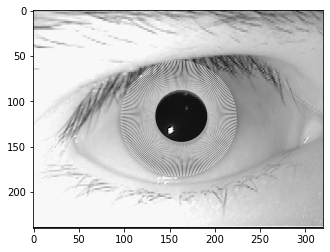

In [14]:
norm = normalize_iris(img_grey, pup_xy, pup_r, iris_xy, iris_r, 240, 240,
                  method = "Daug", plot = True)


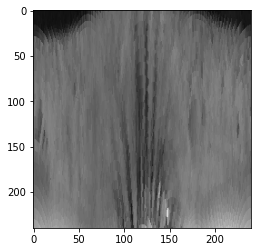

In [15]:
plt.imshow(norm, cmap="gray", vmin=0., vmax=1.)


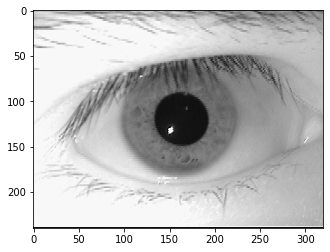

In [16]:
plt.imshow(img_grey, cmap="gray", vmin=0., vmax=1.)


It does seem to work

Let's now go for the wavelets

In [17]:
"""
This is the definition of a 2D Gabor wavelet in polar coordinates.
omega, alpha, beta are parameters,
theta0, r0 are anchor points,
rho and phi are the polar coordinates in wavelet space.
"""
def gabor_wavelet_2D(rho, phi, omega, theta0, r0, alpha, beta):
    return np.exp( -1j*omega * (theta0 - phi) ) * np.exp( -(rho - r0)**2 / alpha**2 ) * np.exp(-(phi - theta0)**2 / beta**2)


In [18]:
"""
Calculates the double integral from Kaugman for a given normalized 
image and some fixed value (theta0, r0). By taking the sign of the 
real and imaginary part of the returned number one can form the bits.
"""

def project_gabor(tranf_img, theta0, r0, omega, alpha, beta):
    n_rho = tranf_img.shape[0]
    n_phi = tranf_img.shape[1]
    ph = np.linspace(0., 2*np.pi, n_phi)
    rh = np.linspace(0., 1., n_rho)
    Phi, Rho = np.meshgrid(ph, rh)
    return np.mean(Rho * tranf_img * gabor_wavelet_2D(Rho, Phi, omega, theta0, r0, alpha, beta))


I mean it looks good!

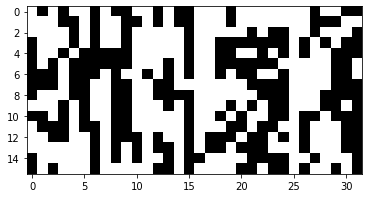

In [22]:
"""
Produces the iriscode from greyscale image img.
theta_psize=15, r_psize=15 are odd number so that the center point is 
included in the window.
alpha ranges from 0.15 to 1.2 mm of the iris, which is about 12 mm, and 
should therefore be between 0.1 and 0.01. 
omega is supposed to span three octaves and is inversely proportional
to beta.
"""
def calculate_iris_code(transf_img, theta_psize=15, r_psize=15, 
                alpha=0.1, omega=16):
    # Impose the demand that the dimensions of the transfromed iris is 
    # divisible by the patch sizes.
    assert(transf_img.shape[0]%r_psize == 0) 
    assert(transf_img.shape[1]%theta_psize == 0)
    
    # Create the code matrix. Each row is a different w.
    iriscode = np.zeros([transf_img.shape[0]//r_psize, 
                         transf_img.shape[1]//theta_psize * 2])
    
    # beta is inversely proportional
    beta = 1./alpha
    
    norm_img = (transf_img - np.mean(transf_img))/np.std(transf_img)
    # The iriscode is calculated from each patch
    for i in range(transf_img.shape[0]//r_psize):
        for j in range(transf_img.shape[1]//theta_psize):
            pi = i*r_psize
            pj = j*theta_psize
            patch = norm_img[np.ix_(np.arange(pi, pi+r_psize), np.arange(pj, pj+theta_psize))]
            #patch = transf_img[pi:pi+r_psize][pj:pj+theta_psize]
            #project_gabor(img, np.pi, 0.5, 8, 0.4, 1.4)
            h = project_gabor(patch, np.pi, 0.5, omega, alpha, beta)
            #wavelet = gabor_convolve(p, w, alpha, 1 / alpha)
            iriscode[i, j*2] = np.real(h)
            iriscode[i, j*2+1] = np.imag(h)
    iriscode[iriscode >= 0] = 1
    iriscode[iriscode < 0] = 0
    return iriscode.flatten()

code = calculate_iris_code(norm, theta_psize=15, r_psize=15, 
                alpha=0.4, omega=16)
plt.imshow(code.reshape([16, 32]), cmap="gray", vmin=0., vmax=1.)